In [44]:
#Test for People detection using AlexNet + FC regression model
#Network will output yes or no and bounding box for detection
import numpy as np
import os
import tensorflow as tf
import cv2

In [45]:
#Read in all inputs
#input images and bounding boxes
image_files = os.listdir('images')
labels = os.listdir('xml')

In [46]:
import random
#Lets see a random image
#random.seed(23)
#index = random.randint(0, len(image_files))
index = 3763
img = cv2.imread(os.path.join('images',image_files[index]),1)

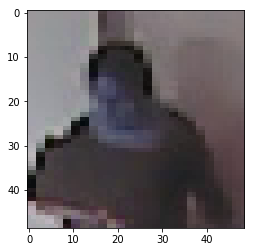

In [47]:
# Will use matplotlib for showing the image
from matplotlib import pyplot as plt

# Plot inline
%matplotlib inline
plt.imshow(img)

In [48]:
#Lets take a look at bounding box label
xml_file = os.path.join('xml',labels[index])
label_file = open(xml_file , 'r')
lines = label_file.read()
print(lines)
label_file.close()

1 7 7 31 32


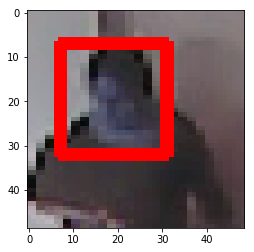

In [49]:
#The format of the label file is 0 x x x x if nothing is present in the image and 1 x0 y0 x1 y1 if there is an object present
#Lets use re to get the coordinates and plot the image
import re
pattern = re.compile(r"(\d+) (\d+) (\d+) (\d+) (\d+)")
matchObj = pattern.findall(lines)
if matchObj:
    is_present = int(matchObj[0][0])
    if is_present == 1:
        x0 = int(matchObj[0][1])
        y0 = int(matchObj[0][2])
        x1 = int(matchObj[0][3])
        y1 = int(matchObj[0][4])
        cv2.rectangle(img,(x0,y0),(x1,y1),(255,0,0),2)
plt.imshow(img)

In [50]:
#Lets us look at total images
print(len(image_files))
print(len(labels))

5880
5880


In [51]:
#Read all these and populate np array
#Read images
allImage = np.zeros([len(image_files),49,49,3])
for i in range(0,len(image_files)):
    img = cv2.imread(os.path.join('images',image_files[i]),1)
    allImage[i]=img
print(allImage.shape)

(5880, 49, 49, 3)


In [52]:
#Read labels and convert to one hot encoded
all_labels = np.zeros([len(labels),6])
#all_labels = np.zeros([len(labels),2])
import re
for i in range(0,len(labels)):
    label_file = open(os.path.join('xml',labels[i]) , 'r')
    lines = label_file.read()
    label_file.close()
    pattern = re.compile(r"(\d+) (\d+) (\d+) (\d+) (\d+)")
    matchObj = pattern.findall(lines)
    if matchObj:
        is_present = int(matchObj[0][0])
        if is_present == 1:
            not_present = 0
            present = 1            
            x0 = int(matchObj[0][1])
            y0 = int(matchObj[0][2])
            x1 = int(matchObj[0][3])
            y1 = int(matchObj[0][4])
        else:
            not_present = 1
            present = 0        
            x0 = 0
            y0 = 0
            x1 = 0
            y1 = 0
    all_labels[i] = [not_present,present,x0,y0,x1,y1]
    #all_labels[i] = [not_present,present]
print(all_labels.shape)

(5880, 6)


In [53]:
#Test validation split + randomize order
tf.random_shuffle(allImage, seed=181)
tf.random_shuffle(all_labels, seed=181)
import sklearn.model_selection as sk

X_train, X_test, y_train, y_test = sk.train_test_split(allImage,all_labels,test_size=0.20, random_state = 42)

In [54]:
print(len(X_train))
print(len(y_train))

print(len(X_test))
print(len(y_test))

4704
4704
1176
1176


In [19]:
#There are approximate 3000 negatives and 2880 positive images. The images are taken from a 640x480 image and cropped with a 8
#pixel sliding window. If the bounding box is completely encompassed in the 49x49 frame it is stored as label for the image

In [20]:
#Setup tensorflow

#Setup inputs
x = tf.placeholder("float", [None, 49, 49, 3], name='x')#Image
y = tf.placeholder("float", [None, 6], name='y')#Label and boundingbox
#y = tf.placeholder("float", [None, 2], name='y')#Label and boundingbox

In [21]:
#Setup classification network, using AlexNet as reference with minor changes in first and last layers

############################Layer 1
weight_1 = tf.Variable(tf.truncated_normal([3, 3, 3, 48]))#Kernal size changed from 11 to 3 and stride from 4 to 1        
bias_1 = tf.Variable(tf.zeros(48))

#Apply convolution
conv_layer_1 = tf.nn.conv2d(x, weight_1, strides=[1,1,1,1], padding='VALID')
# Add bias
conv_layer_1 = tf.nn.bias_add(conv_layer_1, bias_1)

# Apply activation function
conv_layer_1 = tf.nn.relu(conv_layer_1)      
conv_layer_1 = tf.nn.max_pool(conv_layer_1,ksize=[1,3,3,1],strides=[1,2,2,1],padding='VALID')

print(conv_layer_1.get_shape())
#############################Layer 2
weight_2 = tf.Variable(tf.truncated_normal([5, 5, 48, 128]))
bias_2 = tf.Variable(tf.zeros(128))

#Apply convolution
conv_layer_2 = tf.nn.conv2d(conv_layer_1, weight_2, strides=[1,1,1,1], padding='VALID')
# Add bias
conv_layer_2 = tf.nn.bias_add(conv_layer_2, bias_2)

# Apply activation function
conv_layer_2 = tf.nn.relu(conv_layer_2)      
conv_layer_2 = tf.nn.max_pool(conv_layer_2,ksize=[1,3,3,1],strides=[1,2,2,1],padding='VALID')

print(conv_layer_2.get_shape())
#############################Layer 3
weight_3 = tf.Variable(tf.truncated_normal([3, 3, 128, 192]))
bias_3 = tf.Variable(tf.zeros(192))

#Apply convolution
conv_layer_3 = tf.nn.conv2d(conv_layer_2, weight_3, strides=[1,1,1,1], padding='VALID')
# Add bias
conv_layer_3 = tf.nn.bias_add(conv_layer_3, bias_3)
# Apply activation function
conv_layer_3 = tf.nn.relu(conv_layer_3)      

print(conv_layer_3.get_shape())

weight_4 = tf.Variable(tf.truncated_normal([3, 3, 192, 192]))
bias_4 = tf.Variable(tf.zeros(192))

#Apply convolution
conv_layer_3 = tf.nn.conv2d(conv_layer_3, weight_4, strides=[1,1,1,1], padding='VALID')
# Add bias
conv_layer_3 = tf.nn.bias_add(conv_layer_3, bias_4)
# Apply activation function
conv_layer_3 = tf.nn.relu(conv_layer_3)      

print(conv_layer_3.get_shape())

weight_5 = tf.Variable(tf.truncated_normal([3, 3, 192, 128]))
bias_5 = tf.Variable(tf.zeros(128))

#Apply convolution
conv_layer_3 = tf.nn.conv2d(conv_layer_3, weight_5, strides=[1,1,1,1], padding='VALID')
# Add bias
conv_layer_3 = tf.nn.bias_add(conv_layer_3, bias_5)
# Apply activation function
conv_layer_3 = tf.nn.relu(conv_layer_3)  

conv_layer_3 = tf.nn.max_pool(conv_layer_3,ksize=[1,3,3,1],strides=[1,2,2,1],padding='VALID')

print(conv_layer_3.get_shape())


(?, 23, 23, 48)
(?, 9, 9, 128)
(?, 7, 7, 192)
(?, 5, 5, 192)
(?, 1, 1, 128)


In [22]:
#Create classification layer for label
#############################Layer 4
dim = conv_layer_3.get_shape().as_list()  
fc_1 = tf.reshape(conv_layer_3, [-1,dim[1]*dim[2]*dim[3]])     

dim = fc_1.get_shape().as_list()  
fc_weight_1 = tf.Variable(tf.truncated_normal([dim[1], 2048]))        
fc_bias_1 = tf.Variable(tf.zeros(2048))
    
# Apply multiplication        
fc_layer_1 = tf.matmul(fc_1, fc_weight_1)
# Add bias
fc_layer_1 = tf.nn.bias_add(fc_layer_1, fc_bias_1)
# Apply activation function
fc_layer_1 = tf.nn.relu(fc_layer_1)          

print(fc_layer_1.get_shape())
#############################Layer 5
dim = fc_layer_1.get_shape().as_list()  
fc_weight_2 = tf.Variable(tf.truncated_normal([dim[1], 2048]))        
fc_bias_2 = tf.Variable(tf.zeros(2048))
    
# Apply multiplication        
fc_layer_2 = tf.matmul(fc_layer_1, fc_weight_2)
# Add bias
fc_layer_2 = tf.nn.bias_add(fc_layer_2, fc_bias_2)
# Apply activation function
fc_layer_2 = tf.nn.relu(fc_layer_2, name='fc_layer_2')          

print(fc_layer_2.get_shape())
#############################Layer 6
#Output label and bounding box
dim = fc_layer_2.get_shape().as_list()  
fc_weight_3 = tf.Variable(tf.truncated_normal([dim[1], 2]))        
fc_bias_3 = tf.Variable(tf.zeros(2))
#fc_weight_3 = tf.Variable(tf.truncated_normal([dim[1], 2]))        
#fc_bias_3 = tf.Variable(tf.zeros(2))
# Apply multiplication        
fc_layer_3 = tf.matmul(fc_layer_2, fc_weight_3)
# Add bias
classification_output_layer = tf.nn.bias_add(fc_layer_3, fc_bias_3, name='output_layer')
#OutputBox = tf.identity(output_layer, name='output')

print(classification_output_layer.get_shape())

(?, 2048)
(?, 2048)
(?, 2)


In [23]:
#define loss
ce_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=classification_output_layer, labels=y[:,:2]))
optimizer = tf.train.AdamOptimizer().minimize(ce_loss)


In [24]:
# Accuracy
correct_pred = tf.equal(tf.argmax(classification_output_layer, 1), tf.argmax(y[:,:2], 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')


In [25]:
def mean_square_loss(bboxes1, bboxes2):
    """
    Args:
        bboxes1: shape (total_bboxes1, 6)
            with np, p, x1, y1, x2, y2 point order.
        bboxes2: shape (total_bboxes2, 6)
            with np, p, x1, y1, x2, y2 point order.
        p1 *-----
           |     |
           |_____* p2
    Returns:
        Tensor with shape (total_bboxes1, total_bboxes2)
        with the IoU (intersection over union) of bboxes1[i] and bboxes2[j]
        in [i, j].
    """

    not_present_ref = bboxes1[:,0]
    present_ref = bboxes1[:,1]    
    x11 = bboxes1[:,2]
    y11 = bboxes1[:,3]
    x12 = bboxes1[:,4]
    y12 = bboxes1[:,5]
    
    not_present_ref = bboxes2[:,0]
    present_ref = bboxes2[:,1]
    x21 = bboxes2[:,2]
    y21 = bboxes2[:,3]
    x22 = bboxes2[:,4]
    y22 = bboxes2[:,5]
    
    prediction = tf.nn.softmax(bboxes2[:,:2])
    correct_pred = tf.equal(tf.argmax(bboxes1[:,:2], 1), tf.argmax(prediction, 1))
    
    #if prediction is correct then compare bboxes predicted, if they are not equal return a 1(maximum error)
    #if prediction is correct return the bounding box iou error
    
    #x11, y11, x12, y12 = tf.split(bboxes1, 4, axis=1)
    #x21, y21, x22, y22 = tf.split(bboxes2, 4, axis=1)

    #xI1 = tf.maximum(x11, x21)
    #yI1 = tf.maximum(y11, y21)

    #xI2 = tf.minimum(x12, x22)
    #yI2 = tf.minimum(y12, y22)

    #inter_area = (xI2 - xI1 + 1) * (yI2 - yI1 + 1)

    #bboxes1_area = (x12 - x11 + 1) * (y12 - y11 + 1)
    #bboxes2_area = (x22 - x21 + 1) * (y22 - y21 + 1)

    #union = (bboxes1_area + tf.transpose(bboxes2_area)) - inter_area
    
    #iou_loss = tf.minimum(union - inter_area / union, 1)
    
    error1 = tf.sqrt(tf.square(x11 - x21) + tf.square(y11 - y21))
    error2 = tf.sqrt(tf.square(x12 - x22) + tf.square(y12 - y22))
    loss = error1 + error2

    #l0 = tf.ones_like(loss)
    #return (tf.where(correct_pred,loss,l0))
    return (loss)

In [60]:
def train_neural_network(session, optimizer,feature_batch, label_batch, loss):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    # TODO: Implement Function
    session.run(optimizer, feed_dict={
                x: feature_batch,
                y: label_batch})
    loss_ret = session.run(loss, feed_dict={
                           x: feature_batch,
                           y: label_batch})
    return (loss_ret)



In [57]:
def print_stats(session, feature_batch, label_batch, valid_features, valid_labels, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    # TODO: Implement Function
    #bb_loss = session.run(iou_loss, feed_dict={
    #                   x: feature_batch,
    #                   y: label_batch})
    acc = session.run(accuracy, feed_dict={
                       x: valid_features,
                       y: valid_labels})
    #print('Loss: {:>10.2f}Validation Accuracy: {:.2f}'.format(bb_loss,acc))
    print('Validation Accuracy: {:.2f}'.format(acc))
    pass

In [28]:
# TODO: Tune Parameters
epochs = 70
batch_size = 512

In [29]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [30]:
for i in range(0, int(np.ceil(len(X_train)/batch_size))):
    start_index = i*batch_size
    end_index = min(i*batch_size+(batch_size-1),len(X_train))
    print(start_index,end_index)

0 511
512 1023
1024 1535
1536 2047
2048 2559
2560 3071
3072 3583
3584 4095
4096 4607
4608 4704


In [31]:
for epoch in range(epochs):
    for i in range(0, int(np.ceil(len(X_train)/batch_size))):
        start_index = i*batch_size
        end_index = min(i*batch_size+(batch_size-1),len(X_train))
        batch_features = X_train[start_index:end_index]
        batch_labels = y_train[start_index:end_index]    
        
        bb_loss = 0
        class_loss = train_neural_network(sess, optimizer, batch_features, batch_labels,ce_loss)
        
        #class_loss = 0
        #bb_loss = train_neural_network(sess, optimizer, batch_features, batch_labels,reg_loss)
        
        print('Epoch {:>2}, Batch {}, CE Loss {} BB Loss {}:  '.format(epoch + 1, i, class_loss, bb_loss))
        #print_stats(sess, batch_features, batch_labels, X_test, y_test, accuracy)
# Save Model
save_model_path = './final/detect_model_out'
saver = tf.train.Saver()
save_path = saver.save(sess, save_model_path)

Epoch  1, Batch 0, CE Loss 362209378304.0 BB Loss 0:  
Epoch  1, Batch 1, CE Loss 189077012480.0 BB Loss 0:  
Epoch  1, Batch 2, CE Loss 227383197696.0 BB Loss 0:  
Epoch  1, Batch 3, CE Loss 86285828096.0 BB Loss 0:  
Epoch  1, Batch 4, CE Loss 124015075328.0 BB Loss 0:  
Epoch  1, Batch 5, CE Loss 171858804736.0 BB Loss 0:  
Epoch  1, Batch 6, CE Loss 46373326848.0 BB Loss 0:  
Epoch  1, Batch 7, CE Loss 75421270016.0 BB Loss 0:  
Epoch  1, Batch 8, CE Loss 87714521088.0 BB Loss 0:  
Epoch  1, Batch 9, CE Loss 77238878208.0 BB Loss 0:  
Epoch  2, Batch 0, CE Loss 61435138048.0 BB Loss 0:  
Epoch  2, Batch 1, CE Loss 47209349120.0 BB Loss 0:  
Epoch  2, Batch 2, CE Loss 63920758784.0 BB Loss 0:  
Epoch  2, Batch 3, CE Loss 85073649664.0 BB Loss 0:  
Epoch  2, Batch 4, CE Loss 47092076544.0 BB Loss 0:  
Epoch  2, Batch 5, CE Loss 35221606400.0 BB Loss 0:  
Epoch  2, Batch 6, CE Loss 30287759360.0 BB Loss 0:  
Epoch  2, Batch 7, CE Loss 48512405504.0 BB Loss 0:  
Epoch  2, Batch 8, CE L

Epoch 16, Batch 6, CE Loss 94619088.0 BB Loss 0:  
Epoch 16, Batch 7, CE Loss 286837280.0 BB Loss 0:  
Epoch 16, Batch 8, CE Loss 89130168.0 BB Loss 0:  
Epoch 16, Batch 9, CE Loss 0.0 BB Loss 0:  
Epoch 17, Batch 0, CE Loss 222570208.0 BB Loss 0:  
Epoch 17, Batch 1, CE Loss 614266112.0 BB Loss 0:  
Epoch 17, Batch 2, CE Loss 94530608.0 BB Loss 0:  
Epoch 17, Batch 3, CE Loss 145144352.0 BB Loss 0:  
Epoch 17, Batch 4, CE Loss 287635072.0 BB Loss 0:  
Epoch 17, Batch 5, CE Loss 58410756.0 BB Loss 0:  
Epoch 17, Batch 6, CE Loss 130656352.0 BB Loss 0:  
Epoch 17, Batch 7, CE Loss 202933328.0 BB Loss 0:  
Epoch 17, Batch 8, CE Loss 21110448.0 BB Loss 0:  
Epoch 17, Batch 9, CE Loss 0.0 BB Loss 0:  
Epoch 18, Batch 0, CE Loss 85227128.0 BB Loss 0:  
Epoch 18, Batch 1, CE Loss 462936640.0 BB Loss 0:  
Epoch 18, Batch 2, CE Loss 138718048.0 BB Loss 0:  
Epoch 18, Batch 3, CE Loss 84543088.0 BB Loss 0:  
Epoch 18, Batch 4, CE Loss 303300224.0 BB Loss 0:  
Epoch 18, Batch 5, CE Loss 30677870

Epoch 32, Batch 8, CE Loss 2958125056.0 BB Loss 0:  
Epoch 32, Batch 9, CE Loss 3502686208.0 BB Loss 0:  
Epoch 33, Batch 0, CE Loss 1805377280.0 BB Loss 0:  
Epoch 33, Batch 1, CE Loss 2970300160.0 BB Loss 0:  
Epoch 33, Batch 2, CE Loss 3597678080.0 BB Loss 0:  
Epoch 33, Batch 3, CE Loss 507334848.0 BB Loss 0:  
Epoch 33, Batch 4, CE Loss 2590630400.0 BB Loss 0:  
Epoch 33, Batch 5, CE Loss 3952098048.0 BB Loss 0:  
Epoch 33, Batch 6, CE Loss 1050888256.0 BB Loss 0:  
Epoch 33, Batch 7, CE Loss 458314656.0 BB Loss 0:  
Epoch 33, Batch 8, CE Loss 1053813824.0 BB Loss 0:  
Epoch 33, Batch 9, CE Loss 602907328.0 BB Loss 0:  
Epoch 34, Batch 0, CE Loss 1113981568.0 BB Loss 0:  
Epoch 34, Batch 1, CE Loss 1448964352.0 BB Loss 0:  
Epoch 34, Batch 2, CE Loss 223356624.0 BB Loss 0:  
Epoch 34, Batch 3, CE Loss 1019159936.0 BB Loss 0:  
Epoch 34, Batch 4, CE Loss 1113949952.0 BB Loss 0:  
Epoch 34, Batch 5, CE Loss 184874784.0 BB Loss 0:  
Epoch 34, Batch 6, CE Loss 150896640.0 BB Loss 0:  

Epoch 48, Batch 9, CE Loss 0.0 BB Loss 0:  
Epoch 49, Batch 0, CE Loss 143151008.0 BB Loss 0:  
Epoch 49, Batch 1, CE Loss 3115492608.0 BB Loss 0:  
Epoch 49, Batch 2, CE Loss 3013904384.0 BB Loss 0:  
Epoch 49, Batch 3, CE Loss 770215936.0 BB Loss 0:  
Epoch 49, Batch 4, CE Loss 259523408.0 BB Loss 0:  
Epoch 49, Batch 5, CE Loss 187532672.0 BB Loss 0:  
Epoch 49, Batch 6, CE Loss 1188968448.0 BB Loss 0:  
Epoch 49, Batch 7, CE Loss 2258420736.0 BB Loss 0:  
Epoch 49, Batch 8, CE Loss 2078671360.0 BB Loss 0:  
Epoch 49, Batch 9, CE Loss 0.0 BB Loss 0:  
Epoch 50, Batch 0, CE Loss 170510560.0 BB Loss 0:  
Epoch 50, Batch 1, CE Loss 771669312.0 BB Loss 0:  
Epoch 50, Batch 2, CE Loss 4479727104.0 BB Loss 0:  
Epoch 50, Batch 3, CE Loss 3369071360.0 BB Loss 0:  
Epoch 50, Batch 4, CE Loss 228155968.0 BB Loss 0:  
Epoch 50, Batch 5, CE Loss 301359328.0 BB Loss 0:  
Epoch 50, Batch 6, CE Loss 4199248640.0 BB Loss 0:  
Epoch 50, Batch 7, CE Loss 5714998784.0 BB Loss 0:  
Epoch 50, Batch 8, 

Epoch 65, Batch 2, CE Loss 0.0 BB Loss 0:  
Epoch 65, Batch 3, CE Loss 0.0 BB Loss 0:  
Epoch 65, Batch 4, CE Loss 28031714.0 BB Loss 0:  
Epoch 65, Batch 5, CE Loss 0.0 BB Loss 0:  
Epoch 65, Batch 6, CE Loss 0.0 BB Loss 0:  
Epoch 65, Batch 7, CE Loss 0.0 BB Loss 0:  
Epoch 65, Batch 8, CE Loss 0.0 BB Loss 0:  
Epoch 65, Batch 9, CE Loss 0.0 BB Loss 0:  
Epoch 66, Batch 0, CE Loss 0.0 BB Loss 0:  
Epoch 66, Batch 1, CE Loss 49002700.0 BB Loss 0:  
Epoch 66, Batch 2, CE Loss 0.0 BB Loss 0:  
Epoch 66, Batch 3, CE Loss 0.0 BB Loss 0:  
Epoch 66, Batch 4, CE Loss 8295137.5 BB Loss 0:  
Epoch 66, Batch 5, CE Loss 0.0 BB Loss 0:  
Epoch 66, Batch 6, CE Loss 0.0 BB Loss 0:  
Epoch 66, Batch 7, CE Loss 0.0 BB Loss 0:  
Epoch 66, Batch 8, CE Loss 0.0 BB Loss 0:  
Epoch 66, Batch 9, CE Loss 0.0 BB Loss 0:  
Epoch 67, Batch 0, CE Loss 0.0 BB Loss 0:  
Epoch 67, Batch 1, CE Loss 31640918.0 BB Loss 0:  
Epoch 67, Batch 2, CE Loss 0.0 BB Loss 0:  
Epoch 67, Batch 3, CE Loss 0.0 BB Loss 0:  
Epoch

In [26]:
sess

In [47]:
# Save Model
#save_model_path = './detect_model'
#saver = tf.train.Saver()
#save_path = saver.save(sess, save_model_path)

#Load model
#Test for People detection using AlexNet + FC regression model
#Network will output yes or no and bounding box for detection
import numpy as np
import os
import tensorflow as tf
import cv2
# Will use matplotlib for showing the image
from matplotlib import pyplot as plt
import re

# Plot inline
%matplotlib inline

#Read in all inputs
#input images and bounding boxes
image_files = os.listdir('images')
labels = os.listdir('xml')

load_model_path = './detect_model'
loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    # Load saved model
    loader = tf.train.import_meta_graph(load_model_path + '.meta')
    loader.restore(sess, load_model_path)

    # Get Tensors from loaded model
    # TODO: Implement Function    
    x = loaded_graph.get_tensor_by_name("x:0")
    y = loaded_graph.get_tensor_by_name("y:0")
    OutputBox = loaded_graph.get_tensor_by_name("output:0")
    
    #Run it on a few images    
    index = 3763
    allImage = np.zeros([1,49,49,3], dtype=float)
    #Read image
    img = cv2.imread(os.path.join('images',image_files[index]),1)
    allImage[0] = img
    
    #Read label box
    all_labels = np.zeros([1,6], dtype=float)
    xml_file = os.path.join('xml',labels[index])
    label_file = open(xml_file , 'r')
    lines = label_file.read()
    label_file.close()
    
    #The format of the label file is 0 x x x x if nothing is present in the image and 1 x0 y0 x1 y1 if there is an object present
    #Lets use re to get the coordinates and plot the image
    pattern = re.compile(r"(\d+) (\d+) (\d+) (\d+) (\d+)")
    matchObj = pattern.findall(lines)
    if matchObj:
        is_present = int(matchObj[0][0])
        if is_present == 1:
            not_present = 0
            present = 1            
            x0 = int(matchObj[0][1])
            y0 = int(matchObj[0][2])
            x1 = int(matchObj[0][3])
            y1 = int(matchObj[0][4])
            cv2.rectangle(img,(x0,y0),(x1,y1),(255,0,0),2)  
        else:
            not_present = 1
            present = 0        
            x0 = 0
            y0 = 0
            x1 = 0
            y1 = 0
        labels = [not_present,present,x0,y0,x1,y1]
        all_labels[0] = labels
        
        
    output_bounding_box = sess.run(
                OutputBox,
                feed_dict={x: allImage, y:all_labels})
    
    plt.imshow(img)
      

In [76]:
#Load model
#Test for People detection using AlexNet + FC regression model
#Network will output yes or no and bounding box for detection
import numpy as np
import os
import tensorflow as tf
import cv2
# Will use matplotlib for showing the image
from matplotlib import pyplot as plt
import re

# Plot inline
%matplotlib inline

#Read in all inputs
#input images and bounding boxes
image_files = os.listdir('images')
labels = os.listdir('xml')

# Load saved model
load_model_path = './final/detect_model_out'
loader = tf.train.import_meta_graph(load_model_path + '.meta')
sess = tf.Session()
loader.restore(sess, load_model_path)

INFO:tensorflow:Restoring parameters from ./final/detect_model_out


In [77]:
loaded_graph = tf.get_default_graph()
# Get Tensors from loaded model
x = loaded_graph.get_tensor_by_name("x:0")
y = loaded_graph.get_tensor_by_name("y:0")
output_layer = loaded_graph.get_tensor_by_name("output_layer:0")
print(x.get_shape())
print(y.get_shape())
print(output_layer.get_shape())
print(x.dtype)
print(y.dtype)
print(output_layer.dtype)
#print(loaded_graph)


(?, 49, 49, 3)
(?, 6)
(?, 2)
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>


In [30]:
#print(tf.get_default_graph().as_graph_def())

In [78]:
#Read in all inputs
#input images and bounding boxes
image_files = os.listdir('images')
labels = os.listdir('xml')

#Run it on a one image
index = 3763
allImage = np.zeros([1,49,49,3], dtype=np.float32)
#Read image
img = cv2.imread(os.path.join('images',image_files[index]),1)
allImage[0] = img

#Read label box
all_labels = np.zeros([1,6], dtype=np.float32)
xml_file = os.path.join('xml',labels[index])
label_file = open(xml_file , 'r')
lines = label_file.read()
label_file.close()

#The format of the label file is 0 x x x x if nothing is present in the image and 1 x0 y0 x1 y1 if there is an object present
#Lets use re to get the coordinates and plot the image
pattern = re.compile(r"(\d+) (\d+) (\d+) (\d+) (\d+)")
matchObj = pattern.findall(lines)
if matchObj:
    is_present = int(matchObj[0][0])
    if is_present == 1:
        not_present = 0
        present = 1            
        x0 = int(matchObj[0][1])
        y0 = int(matchObj[0][2])
        x1 = int(matchObj[0][3])
        y1 = int(matchObj[0][4])
        cv2.rectangle(img,(x0,y0),(x1,y1),(255,0,0),2)  
    else:
        not_present = 1
        present = 0        
        x0 = 0
        y0 = 0
        x1 = 0
        y1 = 0
    labels = [not_present,present,x0,y0,x1,y1]
    all_labels[0] = labels

In [79]:
print(allImage.shape)
print(allImage.dtype)
x
y
#print(tf.get_default_graph().as_graph_def())
#print(sess.run(x,feed_dict={x: allImage}))
#print(sess.run(x,feed_dict={x: allImage}))
#"Placeholder:0"
print(sess.run(output_layer,feed_dict={x: allImage}))

(1, 49, 49, 3)
float32
[[-2.279376e+12  6.140983e+10]]


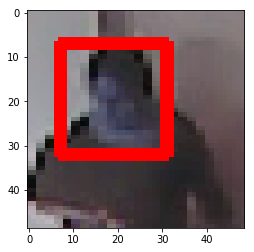

In [80]:
output_bounding_box = sess.run(
                output_layer,
                feed_dict={x: allImage, y:all_labels})
    
plt.imshow(img)

In [81]:
sess = tf.InteractiveSession()
class_label = tf.nn.softmax(output_bounding_box[:,0:2])
print(sess.run(class_label))

c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\client\session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


[[0. 1.]]


In [82]:
#SO it is detecting people correctly, now we need to tune the network for localization
#WE will start with these weights and re-learn with objective for outputing bounding box
sess.run(tf.global_variables_initializer())

In [83]:
#############################Layer 6
fc_layer_2 = loaded_graph.get_tensor_by_name("fc_layer_2:0")
#Output label and bounding box
dim = fc_layer_2.get_shape().as_list()  
fc_weight_det_3 = tf.Variable(tf.truncated_normal([dim[1], 6]))        
fc_bias_det_3 = tf.Variable(tf.zeros(6))
# Apply multiplication        
fc_layer_det_3 = tf.matmul(fc_layer_2, fc_weight_det_3)
# Add bias
detection_output_layer = tf.nn.bias_add(fc_layer_det_3, fc_bias_det_3, name='detection_layer')

print(detection_output_layer.get_shape())

(?, 6)


In [84]:
lambda_noobj = 0.5
output_classes = detection_output_layer[:,0:2]
ref_classes = y[:,0:2]
correct_pred = tf.equal(tf.argmax(output_classes, 1), tf.argmax(ref_classes, 1))
wrong_pred = tf.logical_not(correct_pred)
correct_pred = tf.cast(correct_pred, tf.float32)
wrong_pred = tf.cast(wrong_pred, tf.float32)
class_loss = tf.nn.l2_loss(output_classes - ref_classes)

In [85]:
label_coord = y[:,2:6]/49
lambda_coord = 5
output_bbox = detection_output_layer[:,2:6]
coord_loss = (tf.nn.l2_loss(label_coord[:,0] - output_bbox[:,0])+
              tf.nn.l2_loss(label_coord[:,0] - output_bbox[:,0]) +
              tf.nn.l2_loss(label_coord[:,0] - output_bbox[:,0]) +
              tf.nn.l2_loss(label_coord[:,0] - output_bbox[:,0]))
coord_loss = lambda_coord * coord_loss

In [86]:
correct_loss = (coord_loss + class_loss)
wrong_loss = (lambda_noobj*class_loss)

In [87]:
final_loss = tf.reduce_mean(tf.multiply(correct_pred,correct_loss)+tf.multiply(wrong_pred,wrong_loss))
local_optimizer = tf.train.RMSPropOptimizer(0.01).minimize(final_loss)

In [88]:
# TODO: Tune Parameters
epochs = 100
batch_size = 256

In [89]:
#Train 
for epoch in range(epochs):
    for i in range(0, int(np.ceil(len(X_train)/batch_size))):
        start_index = i*batch_size
        end_index = min(i*batch_size+(batch_size-1),len(X_train))
        batch_features = X_train[start_index:end_index]
        batch_labels = y_train[start_index:end_index]    
        
        bb_loss = 0
        sess.run(local_optimizer, feed_dict={
                x: batch_features,
                y: batch_labels})
        loss_ret = sess.run(final_loss, feed_dict={
                           x: batch_features,
                           y: batch_labels})
        #class_loss = train_neural_network(sess, local_optimizer, batch_features, batch_labels,final_loss)
        
        #class_loss = 0
        #bb_loss = train_neural_network(sess, optimizer, batch_features, batch_labels,reg_loss)
        
        print('Epoch {:>2}, Batch {}, CE Loss {} BB Loss {}:  '.format(epoch + 1, i, class_loss, bb_loss))
        #print_stats(sess, batch_features, batch_labels, X_test, y_test, accuracy)
# Save Model
save_model_path = './localized_model/localize'
saver = tf.train.Saver()
save_path = saver.save(sess, save_model_path)

InvalidArgumentError: You must feed a value for placeholder tensor 'x_1' with dtype float and shape [?,49,49,3]
	 [[Node: x_1 = Placeholder[dtype=DT_FLOAT, shape=[?,49,49,3], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'x_1', defined at:
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\tornado\platform\asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\asyncio\base_events.py", line 345, in run_forever
    self._run_once()
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\asyncio\base_events.py", line 1312, in _run_once
    handle._run()
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\asyncio\events.py", line 125, in _run
    self._callback(*self._args)
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\tornado\platform\asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\IPython\core\interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-acfba8fbaca2>", line 22, in <module>
    loader = tf.train.import_meta_graph(load_model_path + '.meta')
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\training\saver.py", line 1955, in import_meta_graph
    **kwargs)
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\framework\meta_graph.py", line 743, in import_scoped_meta_graph
    producer_op_list=producer_op_list)
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\util\deprecation.py", line 432, in new_func
    return func(*args, **kwargs)
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\framework\importer.py", line 513, in import_graph_def
    _ProcessNewOps(graph)
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\framework\importer.py", line 303, in _ProcessNewOps
    for new_op in graph._add_new_tf_operations(compute_devices=False):  # pylint: disable=protected-access
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\framework\ops.py", line 3540, in _add_new_tf_operations
    for c_op in c_api_util.new_tf_operations(self)
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\framework\ops.py", line 3540, in <listcomp>
    for c_op in c_api_util.new_tf_operations(self)
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\framework\ops.py", line 3428, in _create_op_from_tf_operation
    ret = Operation(c_op, self)
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\framework\ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'x_1' with dtype float and shape [?,49,49,3]
	 [[Node: x_1 = Placeholder[dtype=DT_FLOAT, shape=[?,49,49,3], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [75]:
output_bounding_box = sess.run(
                output_layer,
                feed_dict={x: X_train[1:10], y:y_train[1:10]})

FailedPreconditionError: Attempting to use uninitialized value Variable_15
	 [[Node: Variable_15/read = Identity[T=DT_FLOAT, _class=["loc:@Variable_15"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](Variable_15)]]

Caused by op 'Variable_15/read', defined at:
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\tornado\platform\asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\asyncio\base_events.py", line 345, in run_forever
    self._run_once()
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\asyncio\base_events.py", line 1312, in _run_once
    handle._run()
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\asyncio\events.py", line 125, in _run
    self._callback(*self._args)
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\tornado\platform\asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\IPython\core\interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-acfba8fbaca2>", line 22, in <module>
    loader = tf.train.import_meta_graph(load_model_path + '.meta')
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\training\saver.py", line 1955, in import_meta_graph
    **kwargs)
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\framework\meta_graph.py", line 743, in import_scoped_meta_graph
    producer_op_list=producer_op_list)
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\util\deprecation.py", line 432, in new_func
    return func(*args, **kwargs)
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\framework\importer.py", line 513, in import_graph_def
    _ProcessNewOps(graph)
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\framework\importer.py", line 303, in _ProcessNewOps
    for new_op in graph._add_new_tf_operations(compute_devices=False):  # pylint: disable=protected-access
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\framework\ops.py", line 3540, in _add_new_tf_operations
    for c_op in c_api_util.new_tf_operations(self)
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\framework\ops.py", line 3540, in <listcomp>
    for c_op in c_api_util.new_tf_operations(self)
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\framework\ops.py", line 3428, in _create_op_from_tf_operation
    ret = Operation(c_op, self)
  File "c:\users\npai2\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\framework\ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value Variable_15
	 [[Node: Variable_15/read = Identity[T=DT_FLOAT, _class=["loc:@Variable_15"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](Variable_15)]]
